# 0 环境配置

In [1]:
basedir = "/home/ubuntu/dishui_ddd/input/"

In [2]:
import os
import cv2
import glob
import numpy as np
import pandas as pd

#seed
np.random.seed(2017)
               
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


# 1 预设参数

In [3]:
modelname = "Model9_Xception_DG3_L76"

In [4]:
from keras.applications.xception import preprocess_input

In [5]:
model_image_size = (330, 440)
batch_size = 64
final_layer = 134
visual_layer = 131

# 2 数据生成

In [6]:
gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

valid_generator = gen.flow_from_directory(os.path.join(basedir, 'valid'),  model_image_size, \
                                          shuffle=False, batch_size=batch_size, class_mode="categorical")

Found 2336 images belonging to 10 classes.


In [7]:
steps=valid_generator.samples//batch_size+1
print(steps)

37


# 3 载入模型

In [8]:
model = load_model("models/"+modelname+".h5")

# 4 验证集测试

In [9]:
from sklearn import metrics

In [10]:
map_characters = {0: 'c0', 1: 'c1', 2: 'c2', 
        3: 'c3', 4: 'c4', 5: 'c5', 6: 'c6', 
        7: 'c7', 8: 'c8', 9: 'c9'}

In [11]:
predict = []
y = []
i=0
for x_valid, y_valid in valid_generator:
    predict_batch = model.predict_on_batch(x_valid)
    predict.extend(predict_batch)
    y.extend(y_valid)
    i += 1
    if i== steps:break
y = np.array(y, dtype = float)
predict = np.array(predict, dtype = float)

In [12]:
print('\n', metrics.classification_report(np.where(y > 0)[1], 
                                                  np.argmax(predict, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')



             precision    recall  f1-score   support

         c0       0.87      0.79      0.83       274
         c1       1.00      0.99      1.00       271
         c2       1.00      0.99      1.00       246
         c3       0.92      0.96      0.94       240
         c4       0.99      0.94      0.96       242
         c5       0.99      1.00      1.00       217
         c6       1.00      0.93      0.96       243
         c7       0.86      0.99      0.92       173
         c8       0.79      0.85      0.82       201
         c9       0.84      0.86      0.85       229

avg / total       0.93      0.93      0.93      2336



In [13]:
fname = valid_generator.filenames

# 5 图表分析

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [15]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[216   0   0  12   1   0   0   0  10  35]
 [  1 269   0   1   0   0   0   0   0   0]
 [  0   0 244   0   0   0   0   0   2   0]
 [  2   0   0 230   1   1   0   0   4   2]
 [  0   0   0   5 227   0   0   0  10   0]
 [  0   0   0   0   0 217   0   0   0   0]
 [  0   0   0   0   0   0 225   0  18   0]
 [  0   0   0   0   1   0   0 172   0   0]
 [  1   0   0   0   0   0   1  27 171   1]
 [ 28   0   0   2   0   1   0   0   2 196]]


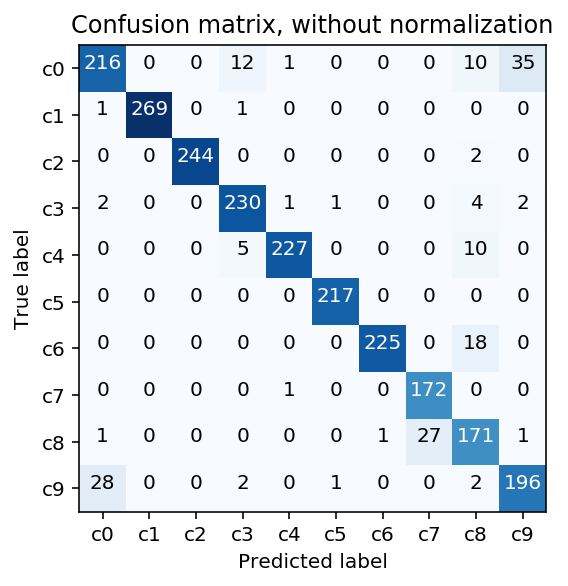

In [16]:
cnf_matrix = metrics.confusion_matrix(np.where(y > 0)[1], np.argmax(predict, axis=1))
class_names = list(map_characters.values())
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
#plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      #title='Normalized confusion matrix')

plt.show()

c0 误判为 c9 c3 c8 
c4 误判为 c8
c6 误判为 c8
c8 误判为 c7
c9 误判为 c0
较多的是在c0,c8,c9三个发生混淆

对比之前的人工7 张错误：
3个talking（C9） 误判为 2个safe(C0),1个不知道
2个safe(C0) 误判为1个talkingC9）,1个不知道
2个化妆(C8) 误判为2个不知道

In [ ]:
发现，和人工的错误还比较一致。
因此，能够改进的空间不大，可能在改善c4和c6的误判，以及c0误判为c3。

# 6 CAM分析

In [17]:
y_test = np.where(y > 0)[1]
y_pred = np.argmax(predict, axis=1)

In [18]:
d = {'filename':pd.Series(fname),
     'y_test':pd.Series(y_test),
     'y_pred':pd.Series(y_pred)  }

In [19]:
df = pd.DataFrame(d)

In [20]:
df.head()

filename  y_pred  y_test
0  c0/img_25298.jpg       9       0
1  c0/img_78742.jpg       0       0
2  c0/img_70820.jpg       0       0
3  c0/img_52476.jpg       0       0
4  c0/img_87270.jpg       0       0

In [21]:
import pickle
pickle.dump(df,open('df_valid','wb'))

In [ ]:
df = pickle.load(open('df_valid', 'rb'))

In [ ]:
df.tail()

In [132]:
def find_image(true,right=True,pred=0):
    if right:
        x = df['filename'][(df['y_test']==true) &(df['y_pred']==true)]
    else:
        #x = df['filename'][(df['y_test']==true) &(df['y_pred']==pred)]
        x1 = df[(df['y_test']==true) &(df['y_pred']!=true)]
        x = x1['filename'][df['y_pred']==pred]
    x = x.sample(n=1).values[0]
    return x

In [166]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

def show_heatmap_image(model_show, weights_show, image_file):
    status = ["safe driving",  " texting - right",  "phone - right",  "texting - left",  "phone - left",  
                  "operation radio", "drinking", "reaching behind", "hair and makeup", "talking"]
    plt.figure()
    img = cv2.imread(basedir+'valid/'+image_file)
    img = cv2.resize(img,  (model_image_size[1],model_image_size[0]))
    img_in = img.copy().astype(np.float32)
    img_in = preprocess_input(img_in)
    out, predictions = model_show.predict_on_batch(np.expand_dims(img_in, axis=0))
    predictions = predictions[0]
    out = out[0]
    
    pred_idx = np.argmax(predictions)
    pred = status[pred_idx]
    prediction = predictions[pred_idx]
    
    val_idx = int(image_file[image_file.rfind('/')-1])  
    val = status[val_idx]

    plt.title('Valid: %s | Pred: %s %.2f%%' % (val, pred, prediction*100))
    
    cam = prediction * np.matmul(out, weights_show)
    cam = cam[:,:,pred_idx]
    cam -= cam.min()
    cam /= cam.max()

    cam = cv2.resize(cam, (model_image_size[1],model_image_size[0]))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0

    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

    plt.axis('off')
    plt.imshow(out[:,:,::-1])

In [24]:
weights = model.layers[final_layer].get_weights()[0]
layer_output = model.layers[visual_layer].output
model2 = Model(model.input, [layer_output, model.output])
print("layer_output {0}".format(layer_output))
print("weights shape {0}".format(weights.shape))

layer_output Tensor("block14_sepconv2_act/Relu:0", shape=(?, 11, 14, 2048), dtype=float32)
weights shape (2048, 10)


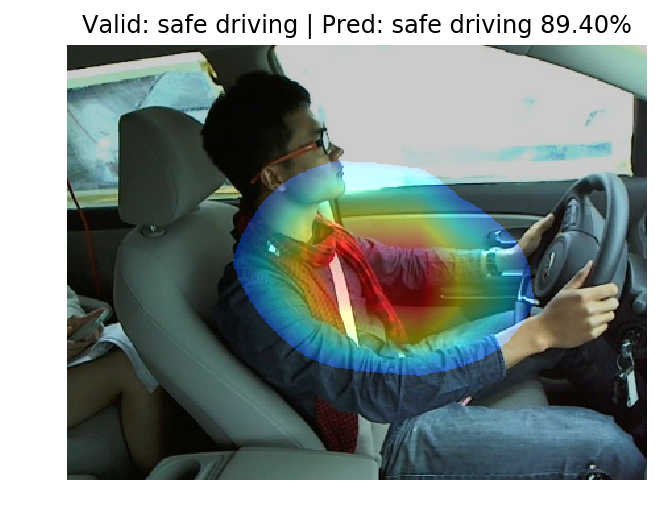

In [155]:
x = find_image(0)
show_heatmap_image(model2, weights, image_file = x)

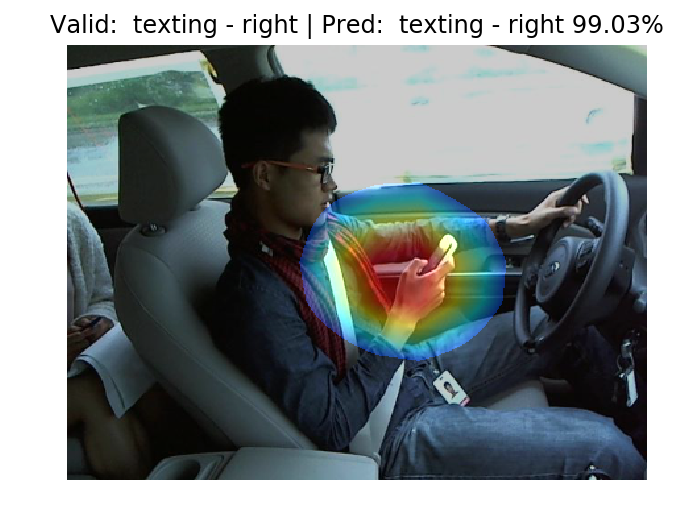

In [58]:
x = find_image(1)
show_heatmap_image(model2, weights, image_file = x)

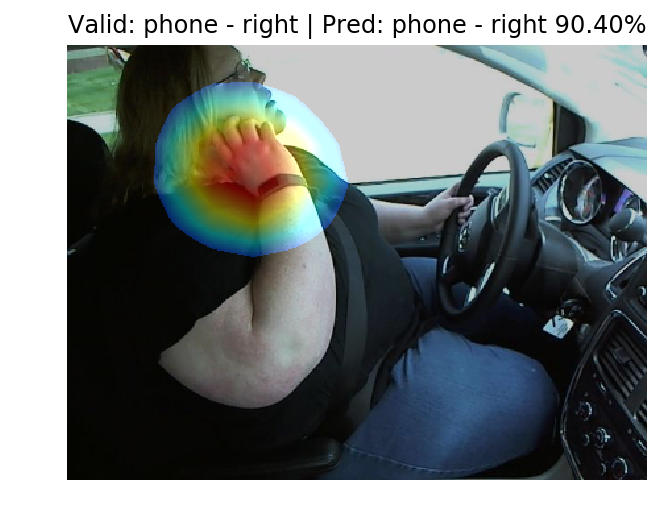

In [66]:
x = find_image(2)
show_heatmap_image(model2, weights, image_file = x)

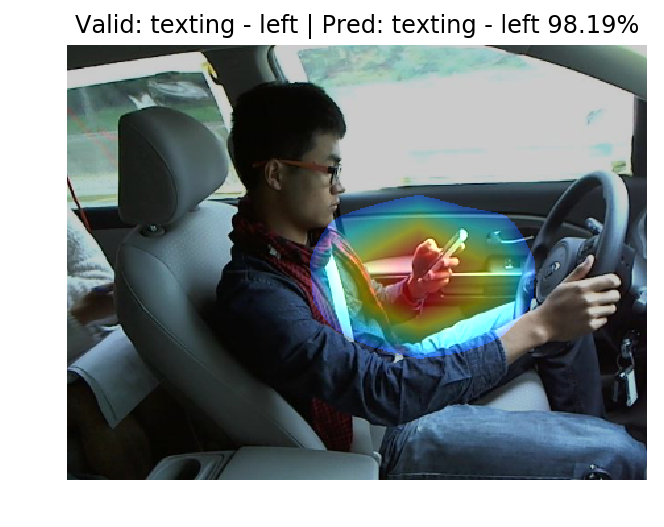

In [67]:
x = find_image(3)
show_heatmap_image(model2, weights, image_file = x)

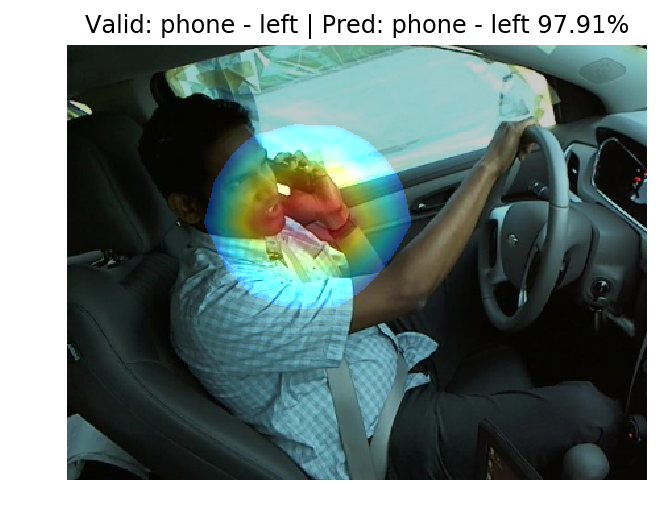

In [69]:
x = find_image(4)
show_heatmap_image(model2, weights, image_file = x)

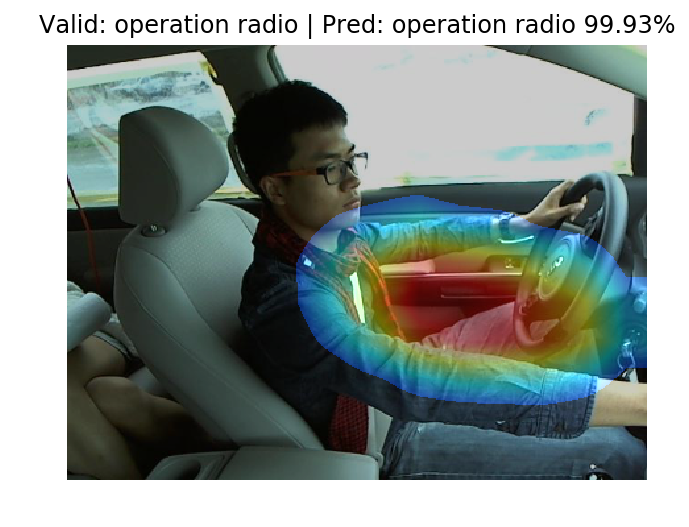

In [156]:
x = find_image(5)
show_heatmap_image(model2, weights, image_file = x)

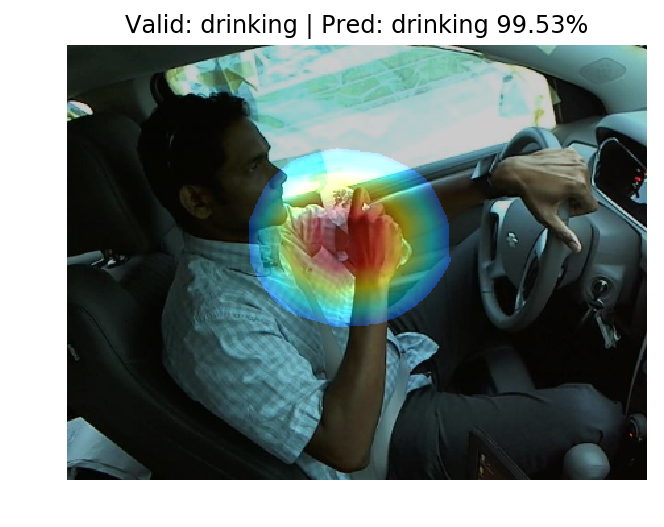

In [94]:
x = find_image(6)
show_heatmap_image(model2, weights, image_file = x)

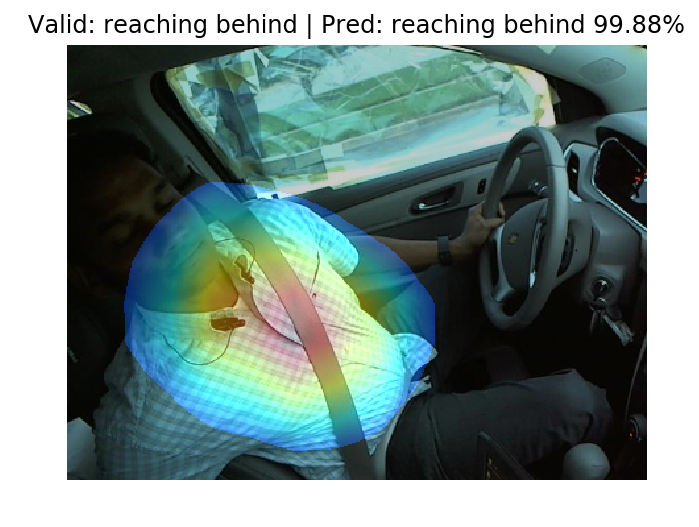

In [157]:
x = find_image(7)
show_heatmap_image(model2, weights, image_file = x)

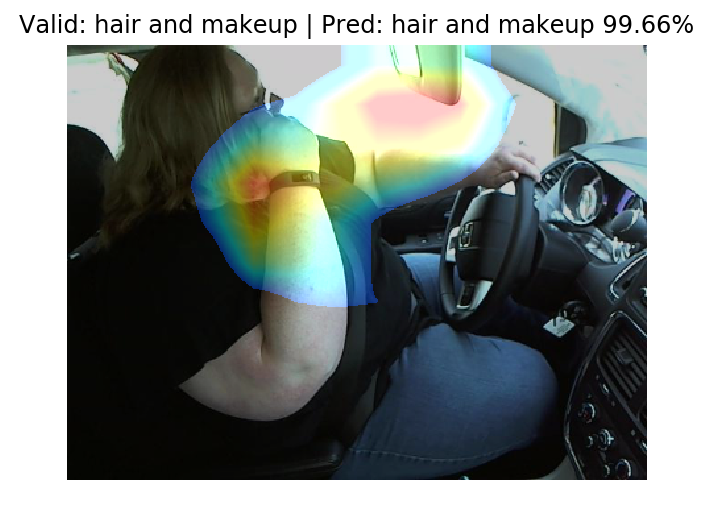

In [97]:
x = find_image(8)
show_heatmap_image(model2, weights, image_file = x)

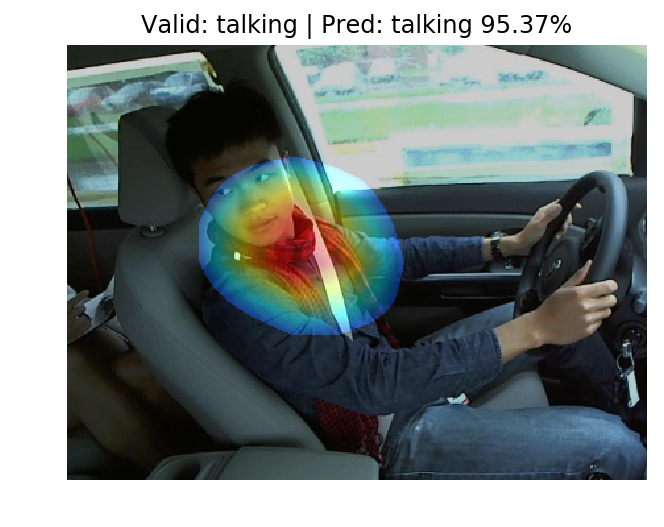

In [98]:
x = find_image(9)
show_heatmap_image(model2, weights, image_file = x)

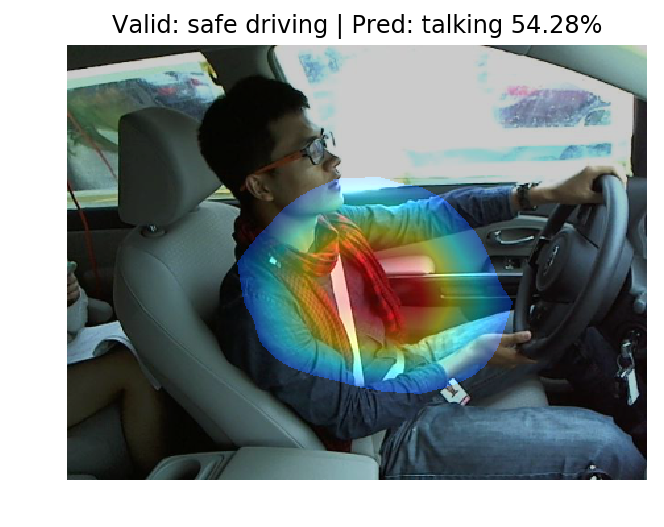

In [163]:
x = find_image(true=0,right=False,pred=9)
show_heatmap_image(model2, weights, image_file = x)

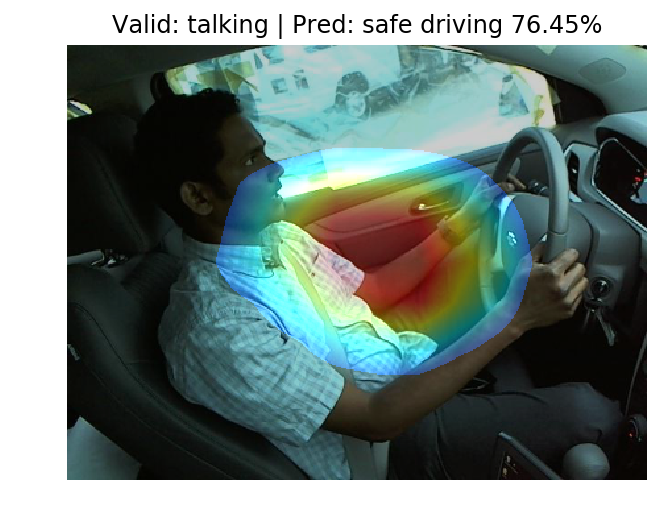

In [164]:
x = find_image(9,False,0)
show_heatmap_image(model2, weights, image_file = x)

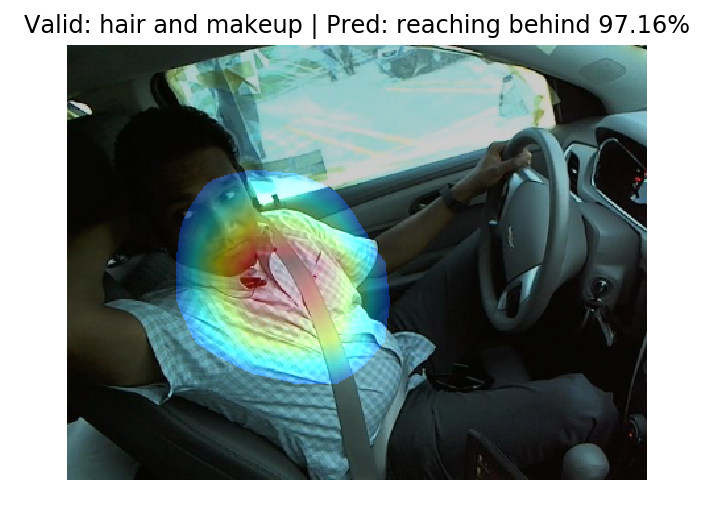

In [110]:
x = find_image(8,False,7)
show_heatmap_image(model2, weights, image_file = x)

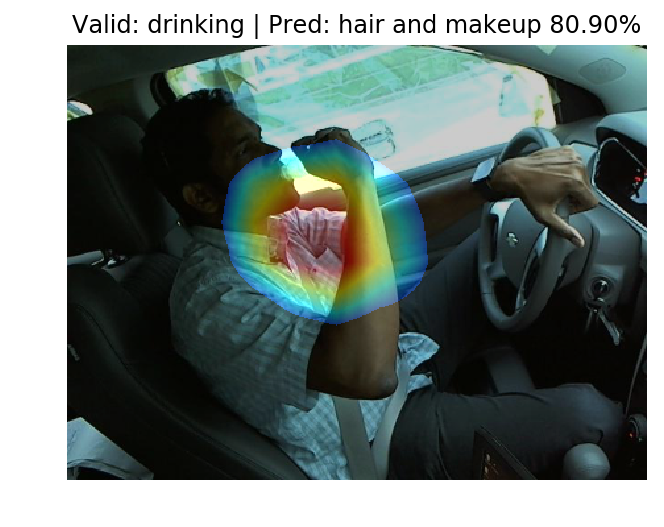

In [119]:
x = find_image(6,False,8)
show_heatmap_image(model2, weights, image_file = x)

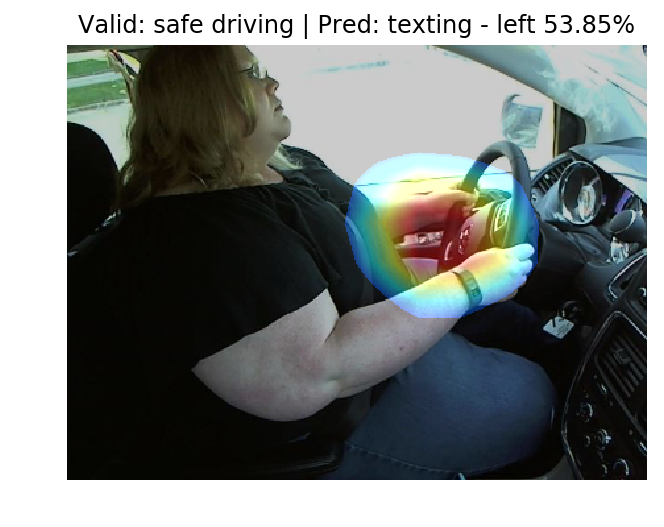

In [142]:
x = find_image(0,False,3)
show_heatmap_image(model2, weights, image_file = x)

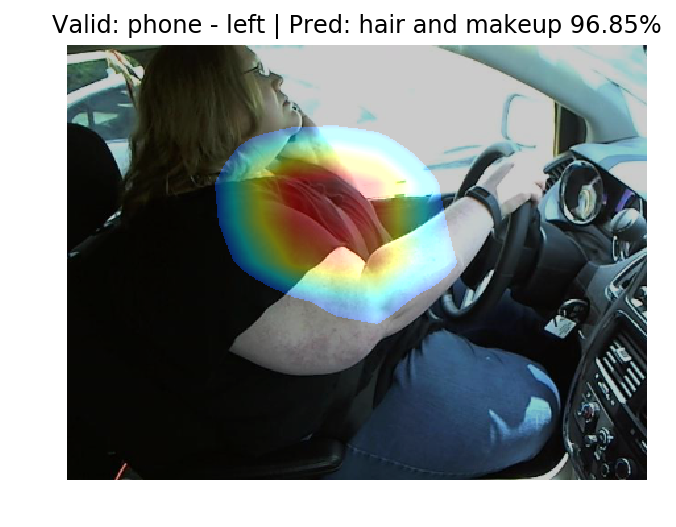

In [129]:
x = find_image(4,False,8)
show_heatmap_image(model2, weights, image_file = x)